# IFT 6758 - Assignment 3 

### Pt 1. Reddit Weekends

*This assignment is based off of Greg Baker's data science course at SFU*

Evaluation on this notebook:

- Histograms for base counts, transformed counts, and central limit theorem counts
- Short answers (last section)

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [41]:
from datetime import date
import scipy.stats as sp

In [42]:
import reddit_weekends

## 1. Load Data

Read the JSON data and filter/clean the dataframe

In [43]:
raw_df = reddit_weekends.read_data("data/reddit-counts.json.gz")

In [44]:
raw_df.head()

,date,subreddit,comment_count
0,2012-02-20,newfoundland,7
1,2015-01-26,Manitoba,1
2,2013-09-07,Yukon,2
3,2014-02-15,saskatchewan,5
4,2014-07-06,canada,1652


In [45]:
# TODO: complete these implementations in reddit_weekends.py
df = reddit_weekends.process_data(raw_df)
wd, we = reddit_weekends.split_data(df)

### T-Test

In [78]:
# TODO: complete this implementations in reddit_weekends.py
p_ttest, p_wdNormal, p_weNormal, p_vartest = reddit_weekends.tests(wd, we, verbose=True)

p_value:	0.0
WD normality:	0.0
WE normality:	0.00152
Variance test:	0.04379


### Fix 1: transforming data might save us.

Have a look at a histogram of the data. You will notice that it's skewed: that's the reason it wasn't normally-distributed in the last part. Try to transform the counts so the data doesn't fail the normality test. Consider the following transforms:

    np.log, np.exp, np.sqrt, counts**2
    
For each transformation, plot the new histogram (`reddit_weekends.draw_histogram()`) and run the `reddit_weekends.tests()` method to see if you can now use the T-test. 
    
Note: none of them will make both distributions pass the normality test. The best I can get one variable with normality problems, one okay; no equal-variance problems.

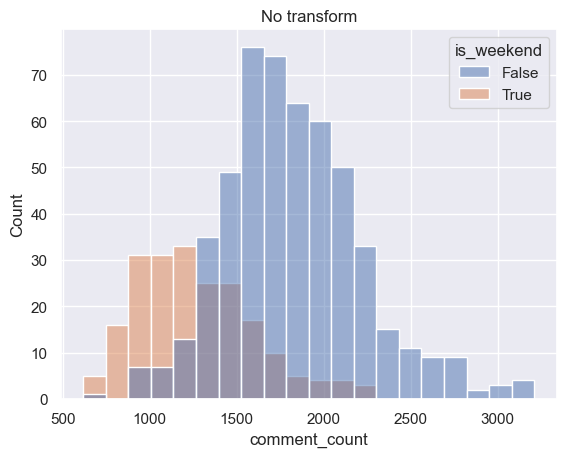

In [47]:
fig = reddit_weekends.draw_histogram(df, title="No transform")

------------------Log transform---------------


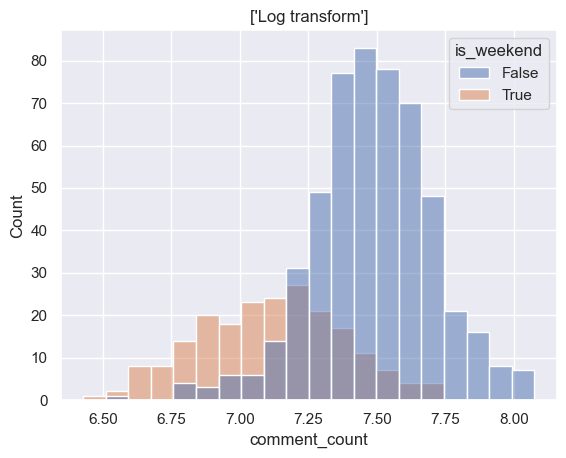

p_value:	0.0
WD normality:	0.0004
WE normality:	0.31494
Variance test:	0.00042


------------------Exp transform---------------


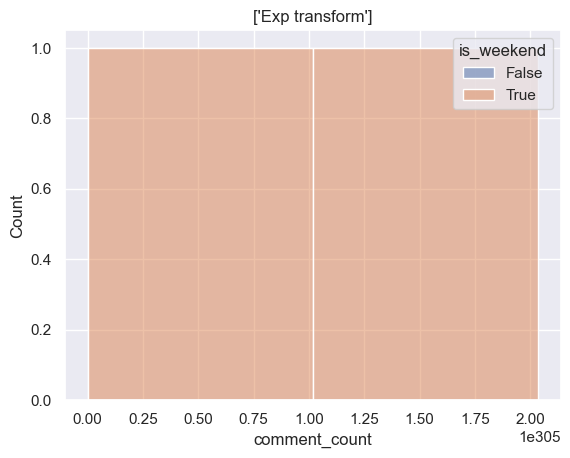

E:\miniconda3\envs\torch_gpu\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
E:\miniconda3\envs\torch_gpu\lib\site-packages\scipy\stats\stats.py:5681: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2
E:\miniconda3\envs\torch_gpu\lib\site-packages\scipy\stats\stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
E:\miniconda3\envs\torch_gpu\lib\site-packages\scipy\stats\morestats.py:2584: RuntimeWarning: invalid value encountered in subtract
  Zij[i] = abs(asarray(args[i]) - Yci[i])


p_value:	nan
WD normality:	nan
WE normality:	nan
Variance test:	nan


------------------Square root transform---------------


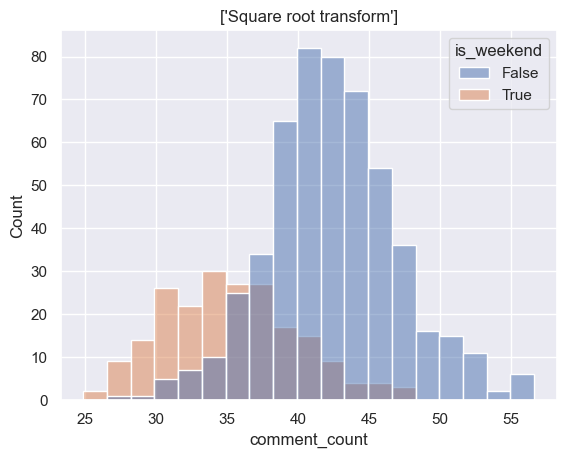

p_value:	0.0
WD normality:	0.03687
WE normality:	0.10761
Variance test:	0.55605


------------------Square transform---------------


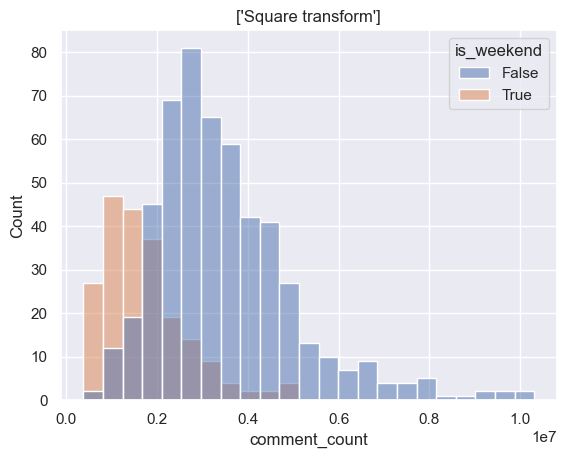

p_value:	0.0
WD normality:	0.0
WE normality:	0.0
Variance test:	0.0




In [49]:
transform_names = {"<ufunc 'log'>": "Log transform",
"<ufunc 'exp'>": "Exp transform",
"<ufunc 'sqrt'>": "Square root transform",
"<ufunc 'square'>": "Square transform"}

for transform in [np.log, np.exp, np.sqrt, np.square]:
    tmp_df = df.copy()
    
    # TODO: apply transform to the copied data (don't overwrite original!)
    tmp_df["comment_count"] = tmp_df["comment_count"].apply(lambda x: transform(x))

    # TODO: draw histogram
    print("------------------{}---------------".format(transform_names[str(transform)]))
    reddit_weekends.draw_histogram(tmp_df, title=[transform_names[str(transform)]])
    plt.show()
    # TODO: re-run tests
    _wd, _we = reddit_weekends.split_data(tmp_df)
    _ = reddit_weekends.tests(_wd, _we, verbose=True)
    print("\n")

### Fix 2: the Central Limit Theorem might save us.

The central limit theorem says that if our numbers are large enough, and we look at sample means, then the result should be normal. 
Let's try that: we will combine all weekdays and weekend days from each year/week pair and take the mean of their (non-transformed) counts.

Hints: you can get a “year” and “week number” from the first two values returned by date.isocalendar(). This year and week number will give you an identifier for the week. Use Pandas to group by that value, and aggregate taking the mean. Note: the year returned by isocalendar isn't always the same as the date's year (around the new year). Use the year from isocalendar, which is correct for this.

Check these values for normality and equal variance. Apply a T-test if it makes sense to do so. (Hint: yay!)

We should note that we're subtly changing the question here. It's now something like “do the number of comments on weekends and weekdays for each week differ?”

In [58]:
# TODO: complete this implementation in reddit_weekends.py
clt = reddit_weekends.central_limit_theorem(df)
clt.head()

comment_count
year-week  is_weekend               
(2011, 52) True                995.0
(2012, 1)  False              1561.6
           True               1163.0
(2012, 2)  False              2062.8
           True               1372.0

p_value:	0.0
WD normality:	0.30826
WE normality:	0.15295
Variance test:	0.20384


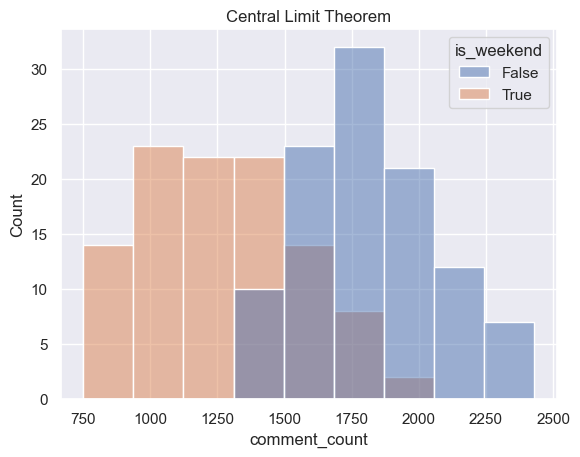

In [69]:
reddit_weekends.draw_histogram(clt, "Central Limit Theorem")

_wd, _we = reddit_weekends.split_data(clt)
_ = reddit_weekends.tests(_wd, _we, verbose=True)

### Fix 3: a non-parametric test might save us.

The other option we have in our toolkit: a statistical test that doesn't care about the shape of its input as much. The Mann–Whitney U-test does not assume normally-distributed values, or equal variance.

Perform a U-test on the (original non-transformed, non-aggregated) counts. Note that we should do a two-sided test here, which will match the other analyses. Make sure you get the arguments to the function correct.

Again, note that we're subtly changing the question again. If we reach a conclusion because of a U test, it's something like “it's not equally-likely that the larger number of comments occur on weekends vs weekdays.”

In [73]:
# TODO: complete this implementation in reddit_weekends.py
p_utest = reddit_weekends.mann_whitney_u_test(wd, we)
print(f"Mann-Whitney U-test p-value: {p_utest}")

Mann-Whitney U-test p-value: 8.6244532347343e-53


# Short Answers

1. Which of the four transforms suggested got you the closest to satisfying the assumptions of a T-test?

* The **square root** transform comes closest to satisfying the asumptions of equal variance and normality of distribution for the T-test. 
* Using this transform we get high likelihood that two samples have equal variance(with a p-value of 0.55). 
* It gives good confidence that comment counts on weekends are normally distributed(p-value=0.10), whereas it doesn't for weekday comment counts. Thus applying this transform still doesn't completely satisfy the normality assumption for the t-test but it's closer to satisfing the assumptions than no transform.



2. I gave imprecise English translations of what the by-week test, and the Mann-Whitney test were actually testing. 
   Do the same for the original T-test, and for the transformed data T-test. 
   That is, describe what the conclusion would be if you could reject the null hypothesis in those tests.

Original T-test: We can't draw an accurate conclusion whether the "average number of comments on weekdays and weekends differ" from this test even though the p-value < 0.05, since the data samples in their current form don't satisy the test's assumptions and thus the test is invalid.  

Transformed data T-test: Using the transformation on the data, we are closer to satisying the test's assumptions although still not perfect. If we were to assume this test is valid, we can conclude that the average number of **commments on weekdays are greater than weekend** by a factor of approx 17(looking at the stat value of the t-test).

3. Of the four approaches, which do you think actually does a better job of getting an answer for the original question: “are there a different number of Reddit comments posted on weekdays than on weekends?” 
   Briefly explain why. (It's not clear that there is a single correct answer to this question, but there are wrong ones!)

The conclusion from Mann-whitney U-test i believe does the best job of answering this question. The test-statistic being used here is the median of the two population as compared to the mean value in the t-tests. Mean value could be influenced by skewed distributions however median is more robust to outliers. The CLT t-test also answers the question, but since the hypothesis consists of an average over weeks, it may not always paint a correct picture. Hence Mann whitney U-test is better.

4. When are more Reddit comments posted in /r/canada, on average: weekdays or weekends? 

More comments are posted on Weekdays compared to weekends. This is evident from the following:
* The average comment counts is higher in the histogram plot of weekdays for both the central limit t-test and the the square root transformed t-test.
* The t-test statistic is a measure of by what factor one statistic is different from the other. The tests suggest this quantity is larger for weekdays.